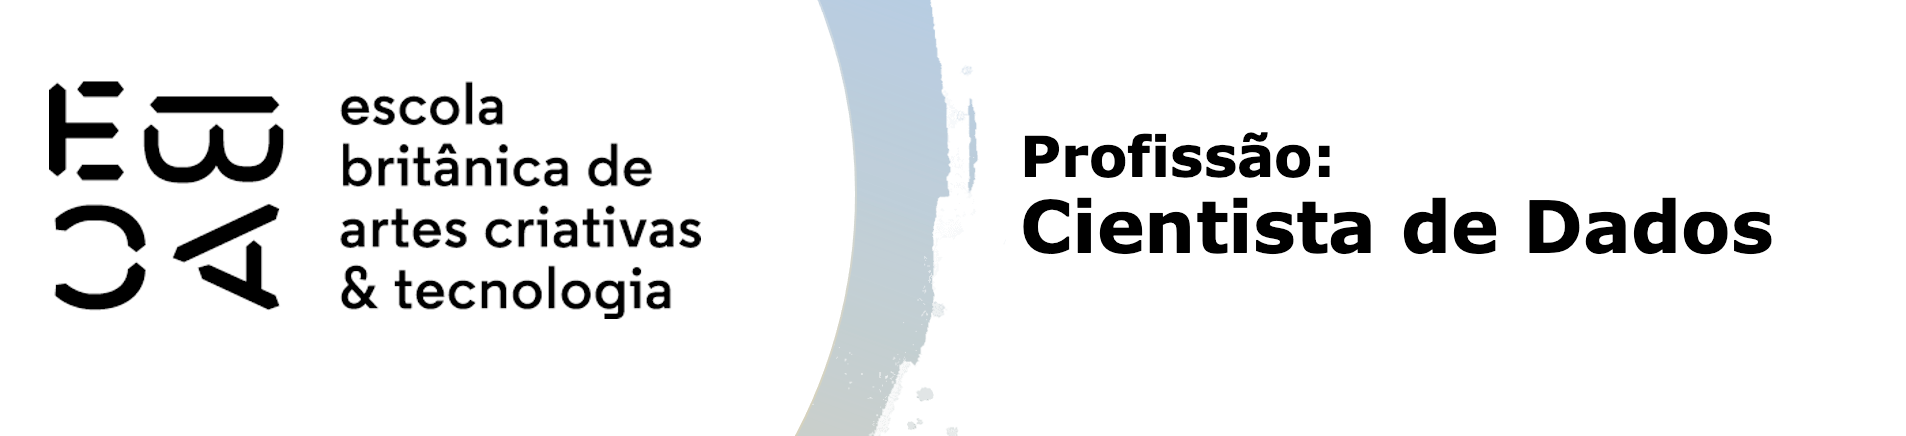

# Modulo 36 Atividade 02
#### João Paulo Costa

## Descritiva IV - Visualização de dados categorizados

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True

# Carrega base
df = pd.read_pickle('base_nfp.pkl').copy()
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'], errors='coerce')
df['evento'] = (df['Retorno'] > 0).astype(int)

# Período de foco: a partir de 2020-01-01 (mantendo consistência)
dt_ini = pd.Timestamp('2020-01-01')
df = df[df['Data Emissão'] >= dt_ini].copy()

In [2]:
# Funções auxiliares
def woe_iv_from_binned(df, feat, y='evento', smooth=1.0):
    grp = df.groupby(feat)[y].agg(['sum','count']).rename(columns={'sum':'bad','count':'total'})
    grp['good'] = grp['total'] - grp['bad']
    total_bad = grp['bad'].sum()
    total_good = grp['good'].sum()
    k = len(grp)
    grp['prop_bad']  = (grp['bad']  + smooth) / (total_bad  + smooth*k)
    grp['prop_good'] = (grp['good'] + smooth) / (total_good + smooth*k)
    grp['WOE'] = np.log(grp['prop_good'] / grp['prop_bad'])
    grp['IV_component'] = (grp['prop_good'] - grp['prop_bad']) * grp['WOE']
    iv_total = grp['IV_component'].sum()
    out = grp.reset_index()[[feat,'bad','good','total','prop_bad','prop_good','WOE','IV_component']]
    return out, iv_total

In [3]:
def iv_for_variable(df, col, y='evento', bins=10, smooth=1.0):
    s = df[col]
    if pd.api.types.is_numeric_dtype(s):
        # cria faixas por quantil e trata valores constantes/nulos
        try:
            binned = pd.qcut(s, q=bins, duplicates='drop')
        except Exception:
            # fallback por bins iguais
            binned = pd.cut(s, bins=min(bins, max(2, s.nunique())), include_lowest=True)
        tmp = df[[y]].copy()
        tmp[col + '_BIN'] = binned.astype(str)
        tab, iv_val = woe_iv_from_binned(tmp, col + '_BIN', y=y, smooth=smooth)
        return tab, iv_val, col + '_BIN'
    else:
        tab, iv_val = woe_iv_from_binned(df[[col, y]].copy(), col, y=y, smooth=smooth)
        return tab, iv_val, col

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [4]:
# Variáveis temporais
df['ano'] = df['Data Emissão'].dt.year
df['mes'] = df['Data Emissão'].dt.month
df['trimestre'] = df['Data Emissão'].dt.quarter
df['semana'] = df['Data Emissão'].dt.isocalendar().week.astype(int)
df['yyyymm'] = df['Data Emissão'].dt.to_period('M').astype(str)

# Variável numérica de valor (ex.: 'Valor NF') para binning
num_col = 'Valor NF'
if num_col in df.columns:
    try:
        df['faixa_valor_nf'] = pd.qcut(df[num_col], q=10, duplicates='drop')
    except Exception:
        # se der erro (muitos empates), usa bins uniformes
        df['faixa_valor_nf'] = pd.cut(df[num_col], bins=10, include_lowest=True)
else:
    df['faixa_valor_nf'] = pd.Series(pd.NA, index=df.index)

print(df[['Data Emissão','yyyymm','ano','mes','trimestre','semana','faixa_valor_nf']].head(5))

      Data Emissão   yyyymm   ano  mes  trimestre  semana   faixa_valor_nf
64598   2020-01-01  2020-01  2020    1          1       1  (66.205, 90.82]
64599   2020-01-01  2020-01  2020    1          1       1   (13.54, 24.05]
64600   2020-01-01  2020-01  2020    1          1       1   (35.48, 49.04]
64601   2020-01-01  2020-01  2020    1          1       1   (13.54, 24.05]
64602   2020-01-01  2020-01  2020    1          1       1  (66.205, 90.82]


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
# Seleção de variáveis candidatas
candidates = []
for c in ['categoria','flag_credito','faixa_valor_nf','ano','mes','trimestre']:
    if c in df.columns:
        candidates.append(c)

iv_results = []
tabs_by_var = {}

for col in candidates:
    tab, iv_val, used_col = iv_for_variable(df, col, y='evento', bins=10, smooth=1.0)
    tabs_by_var[col] = tab
    iv_results.append({'variavel': col, 'col_utilizada': used_col, 'IV': iv_val})

iv_df = pd.DataFrame(iv_results).sort_values('IV', ascending=False).reset_index(drop=True)
print("Ranking por IV:")
display(iv_df)

Ranking por IV:


C:\Users\paulo\AppData\Local\Temp\ipykernel_20468\1121393122.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(feat)[y].agg(['sum','count']).rename(columns={'sum':'bad','count':'total'})


,variavel,col_utilizada,IV
0,categoria,categoria,0.278561
1,faixa_valor_nf,faixa_valor_nf,0.059078
2,mes,mes_BIN,0.007031
3,trimestre,trimestre_BIN,0.000540
4,flag_credito,flag_credito_BIN,0.000000
5,ano,ano_BIN,0.000000


In [6]:
# Mostra a tabela detalhada da top-1 variável
if len(iv_df):
    top_var = iv_df.loc[0,'variavel']
    print(f"\nTabela WOE/IV da variável TOP: {top_var}")
    display(tabs_by_var[top_var].head(20))


Tabela WOE/IV da variável TOP: categoria


,categoria,bad,good,total,prop_bad,prop_good,WOE,IV_component
0,Alimentos,3442,1608,5050,0.092239,0.032409,-1.045951,0.062579
1,Auto posto,135,405,540,0.003643,0.008178,0.808477,0.003666
2,Construção,7523,8524,16047,0.201570,0.171712,-0.160316,0.004787
3,Farmácia,3582,6607,10189,0.095989,0.133100,0.326860,0.012130
4,Mercado,13177,14381,27558,0.353042,0.289685,-0.197792,0.012532
5,Restaurantes,1626,553,2179,0.043588,0.011159,-1.362549,0.044186
6,Varejo,701,4365,5066,0.018807,0.087941,1.542448,0.106636
7,Vestuário,443,1477,1920,0.011895,0.029770,0.917399,0.016399
8,não definido,6689,11718,18407,0.179227,0.236046,0.275377,0.015647


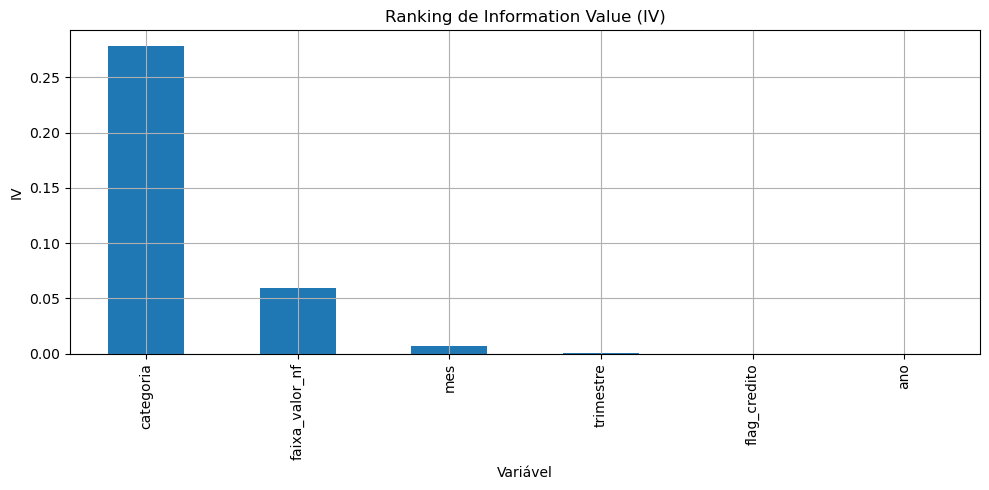

In [7]:
# Gráfico simples do ranking IV
ax = iv_df.plot(kind='bar', x='variavel', y='IV', legend=False)
ax.set_title('Ranking de Information Value (IV)')
ax.set_ylabel('IV')
ax.set_xlabel('Variável')
plt.tight_layout()
plt.show()

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<font color='red'>- As variáveis com **maior IV** demonstram **maior poder de separação** entre notas com e sem `Retorno > 0`. <br>  - Em geral, **categorias** de estabelecimento e **faixas de valor** tendem a apresentar bons IV em bases NFP, pois capturam perfis de consumo distintos.  <br> - Variáveis puramente temporais (`ano`, `trimestre`, `mes`) costumam ter **IV menor**, mas são úteis para **diagnóstico de sazonalidade** e **monitoramento de estabilidade**. </font>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [8]:
# Agregações mensais
agg_mensal = (
    df.groupby('yyyymm')
      .agg(qtd=('evento','size'),
           soma_valor=('Valor NF','sum'),
           taxa_evento=('evento','mean'))
      .reset_index()
      .sort_values('yyyymm')
)
agg_mensal['taxa_evento'] = agg_mensal['taxa_evento'].round(4)
display(agg_mensal.head(12))

,yyyymm,qtd,soma_valor,taxa_evento
0,2020-01,3476,596627.50,0.4954
1,2020-02,3643,492814.92,0.4326
2,2020-03,3465,608268.45,0.3671
3,2020-04,3222,528280.38,0.3541
4,2020-05,3203,524693.51,0.3584
5,2020-06,3185,661108.51,0.3994
6,2020-07,3561,637310.60,0.3909
7,2020-08,3530,606873.74,0.4235
8,2020-09,3625,829219.87,0.4248
9,2020-10,3678,731265.51,0.4415


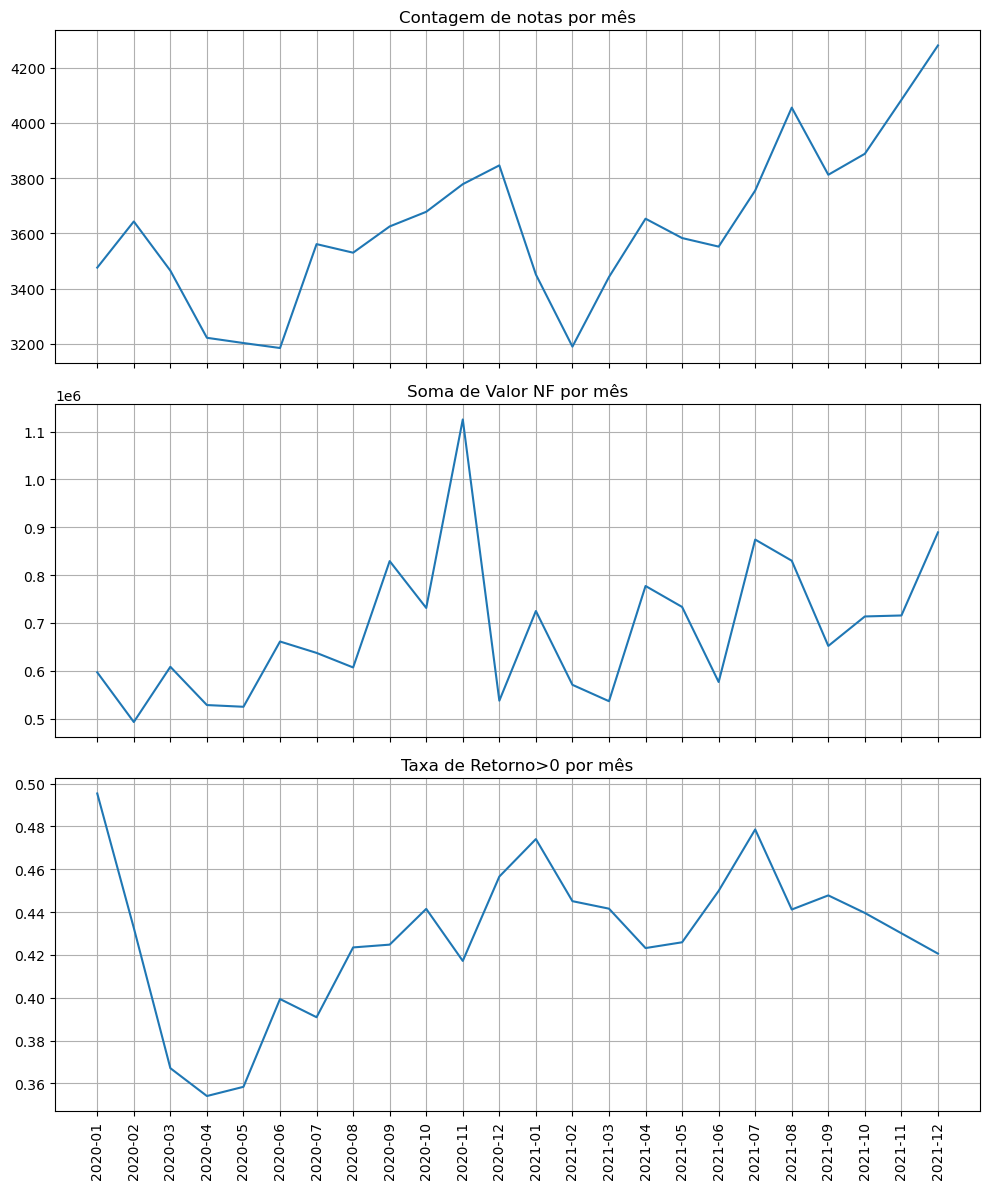

In [9]:
# Gráficos
fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True)
axes[0].plot(agg_mensal['yyyymm'], agg_mensal['qtd'])
axes[0].set_title('Contagem de notas por mês')
axes[1].plot(agg_mensal['yyyymm'], agg_mensal['soma_valor'])
axes[1].set_title('Soma de Valor NF por mês')
axes[2].plot(agg_mensal['yyyymm'], agg_mensal['taxa_evento'])
axes[2].set_title('Taxa de Retorno>0 por mês')
for ax in axes:
    ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [10]:
# WOE/IV por mês para 'categoria'
mensal_iv = []
amostras = []

for yymm, g in df.groupby('yyyymm'):
    try:
        tab, iv_val = woe_iv_from_binned(g[['categoria','evento']], 'categoria', y='evento', smooth=1.0)
        mensal_iv.append({'yyyymm': yymm, 'IV_categoria': iv_val, 'qtd': len(g)})
    except Exception as e:
        mensal_iv.append({'yyyymm': yymm, 'IV_categoria': np.nan, 'qtd': len(g)})

mensal_iv_df = pd.DataFrame(mensal_iv).sort_values('yyyymm').reset_index(drop=True)
display(mensal_iv_df.head(12))

,yyyymm,IV_categoria,qtd
0,2020-01,0.575900,3476
1,2020-02,0.439633,3643
2,2020-03,0.252080,3465
3,2020-04,0.372653,3222
4,2020-05,0.268879,3203
5,2020-06,0.271838,3185
6,2020-07,0.406946,3561
7,2020-08,0.366383,3530
8,2020-09,0.312089,3625
9,2020-10,0.271162,3678


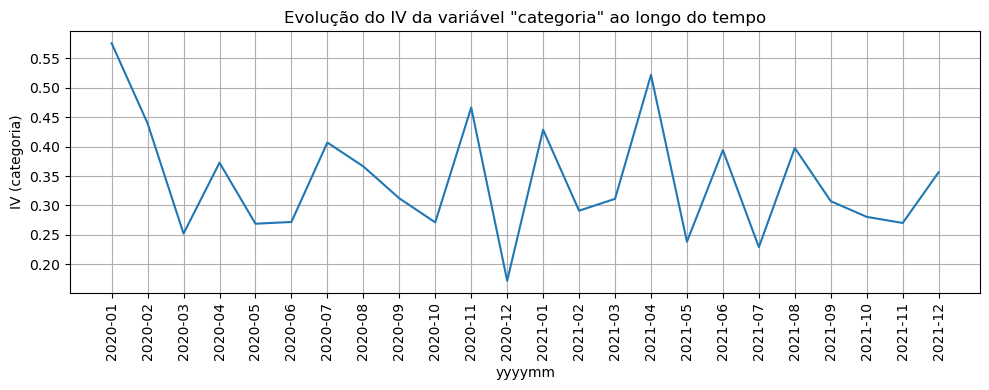

In [11]:
# Gráfico da evolução do IV da 'categoria'
plt.figure(figsize=(10,4))
plt.plot(mensal_iv_df['yyyymm'], mensal_iv_df['IV_categoria'])
plt.title('Evolução do IV da variável "categoria" ao longo do tempo')
plt.xlabel('yyyymm')
plt.ylabel('IV (categoria)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<font color='red'> - **Estabilidade no tempo:** o IV de `categoria` ao longo dos meses indica como o **poder discriminativo** desta variável se mantém (ou não). **Oscilações fortes** sugerem **sensibilidade a conjunturas** (ex.: pandemia, medidas econômicas, sazonalidades).<br> - **Categorias críticas:** categorias com **WOE persistentemente negativo** (maior proporção de eventos) merecem atenção; podem sinalizar perfis com maior probabilidade de `Retorno > 0`.  <br> - **Próximos passos práticos:**  <br> 1. Consolidar categorias raras em **“Outras”** para reduzir ruído.  <br> 2. Manter **monitoramento mensal** do IV/WOE (alertas de drift).<br> 3. Usar as melhores variáveis (maior IV + estabilidade) como **entradas** em um modelo de *scoring* (ex.: Regressão Logística), avaliando calibragem e discriminação. </font>
